# ML Project Assignment - Samuele Ceol

## Classification task on Stroke Prediction Dataset

## Table of Contents
* [CHAPTER 0 - INTRODUCTION](#0)
    * [Section 0.1 - Project rationale & objective](#0.1)
    * [Section 0.2 - Dataset exploration](#0.2)
* [CHAPTER 1 - DATA CURATION](#1)
* [CHAPTER 2 - DEVELOPMENT OF AN ALGORITHM] (#2)
    * [Section 2.1 - Development of a decision tree algorithm] (#2.1) 
    * [Section 2.2 - Development of a random forest algorithm] (#2.2) 
* [CHAPTER 3 - TRAINING THE ALGORITHM](#3)
* [CHAPTER 4 - COMPARING RESULTS WITH AN EXISTING SOLUTION](#4)
* [CHAPTER 5 - CONCLUSIONS](#5)

# CHAPTER 0 - INTRODUCTION <a class="anchor" id="0"></a>

## Section 0.1 - Project rationale & objective <a class="anchor" id="0.1"></a>

## Section 0.2 - Dataset exploration <a class="anchor" id="0.2"></a>

In [1]:
# This block contains all the libraries used in this notebook
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from operator import itemgetter

In [2]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

df.shape

(5110, 12)

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
print(df.gender.unique())
print(df.ever_married.unique())
print(df.work_type.unique())
print(df.Residence_type.unique())
print(df.smoking_status.unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [6]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

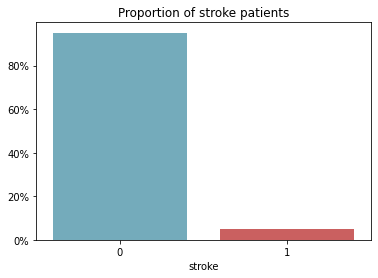

<Figure size 1440x720 with 0 Axes>

In [7]:
def stroke_proportion(curr_df, title):
    g = sns.barplot(
        x='stroke',
        y='stroke',  
        alpha=.75,
        palette=['#3697b5', '#d11313'],
        edgecolor='black',
        linewidth=0,
        data=curr_df,
        estimator=lambda x: len(x) / len(curr_df) * 100
    )
    
    g.yaxis.set_major_formatter(mtick.PercentFormatter())
    g.set_ylabel('')

    plt.title(title)
    plt.figure(figsize=(20, 10))

stroke_proportion(df, "Proportion of stroke patients")

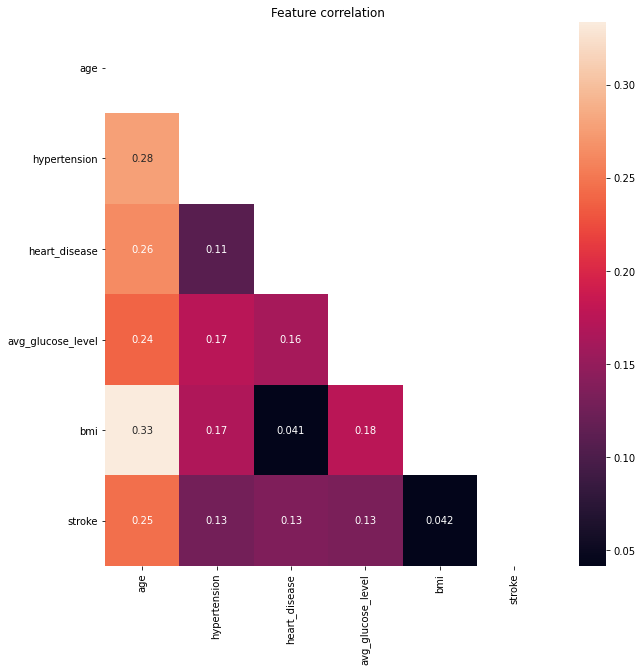

In [8]:
plt.figure(figsize=(10, 10))
plt.title('Feature correlation')

df_corr = df.drop(['id'], axis=1).corr()
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df_corr, 
    linecolor='black', 
    mask=mask,
    annot=True)
plt.show()

# CHAPTER 1 - DATA CURATION <a class="anchor" id="1"></a>

In [9]:
## Trasforming textual values to numeric 
## gender, ever-married, work_type, Residence_type, smoking_status
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in range(len(cols_to_encode)):
    df[cols_to_encode[i]] = LabelEncoder().fit_transform(df[cols_to_encode[i]])

# Drop the single row with gender == 2 ('Other')
df = df[df.gender != 2]

In [10]:
#Since the data is unbalanced, divide it for representation purposes
stroke_df = df[df['stroke'] == 1]
no_stroke_df = df[df['stroke'] == 0]

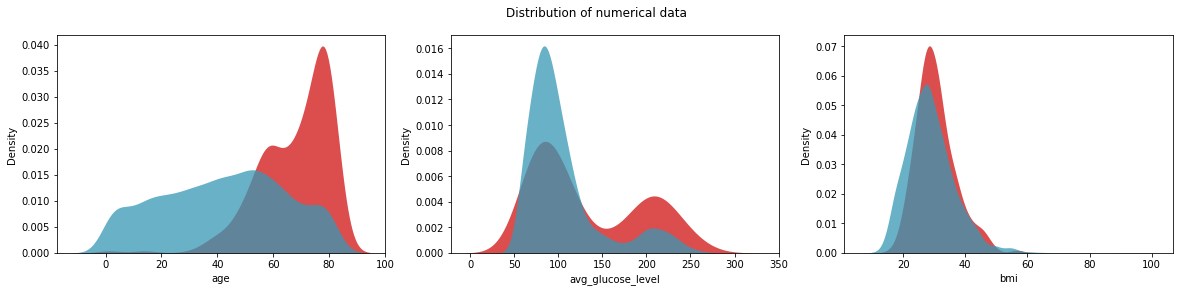

In [11]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']
subplot = 131

fig = plt.figure(figsize=(20, 4))

for i in numeric_features:
    plt.subplot(subplot)

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#d11313',
        shade=True,
        linewidth=0,
        data=stroke_df
    )

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#3697b5',
        shade=True,
        linewidth=0,
        data=no_stroke_df
    )

    subplot += 1

plt.suptitle('Distribution of numerical data')
plt.show()

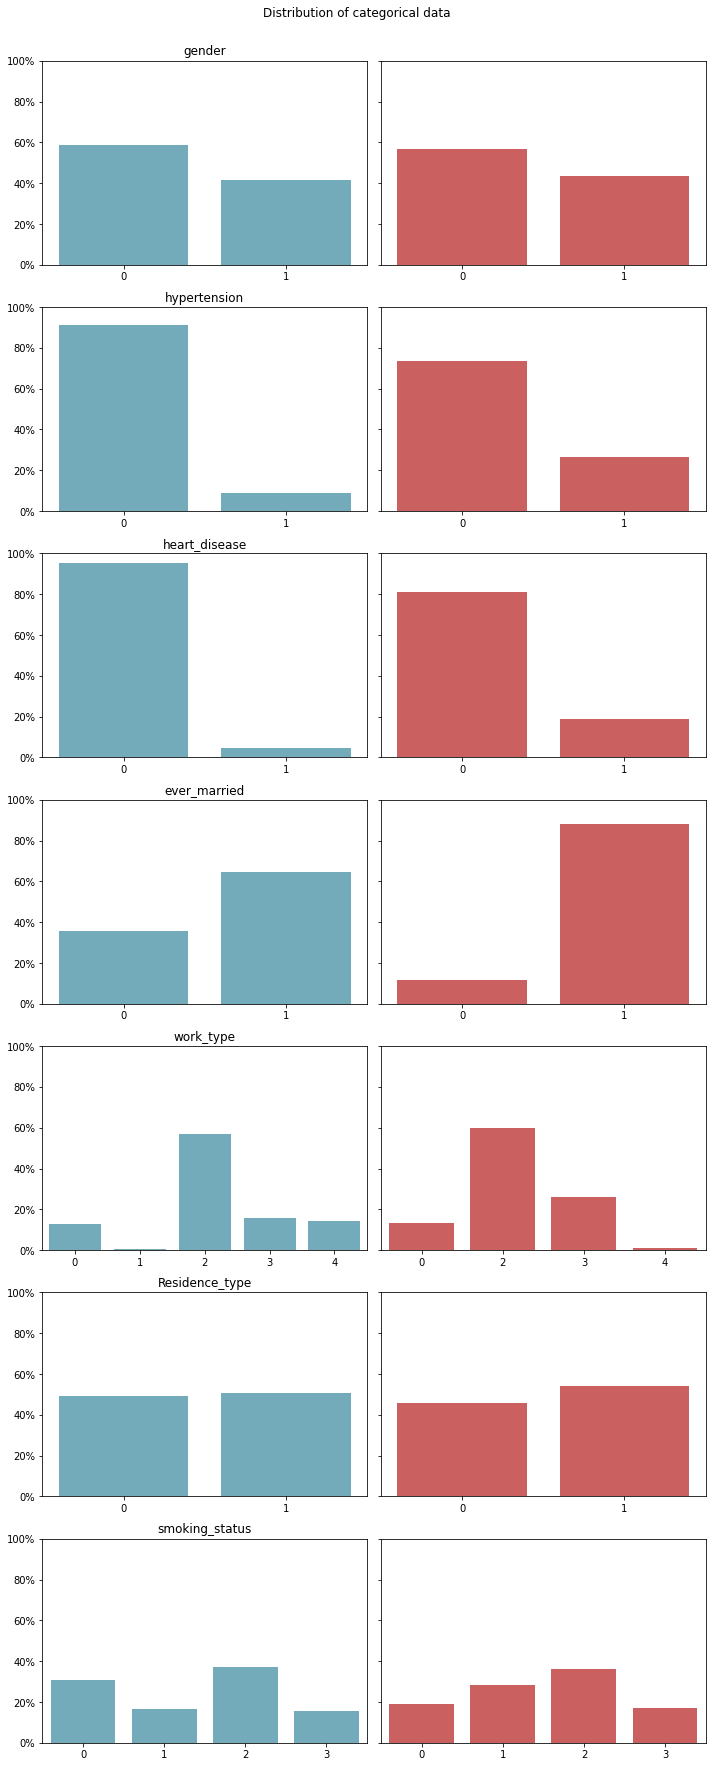

In [12]:
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

fig, ax = plt.subplots(len(categorical_features), 2, figsize=(10, 25), sharey=True)

for i in range(len(categorical_features)):
    feature = categorical_features[i]

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#3697b5',
        data=no_stroke_df, 
        estimator=lambda x: len(x) / len(no_stroke_df) * 100,
        ax=ax[i,0]
    )

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#d11313', 
        data=stroke_df, 
        estimator=lambda x: len(x) / len(stroke_df) * 100,
        ax=ax[i,1]
    )

    ax[i,0].set_title(feature)
    ax[i,0].set_ylabel('')
    ax[i,1].set_ylabel('')
    ax[i,0].set_xlabel('')
    ax[i,1].set_xlabel('')
    ax[i,0].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle('Distribution of categorical data')
plt.show()

In [13]:
## Removing ids
df = df.drop(['id'], axis=1)

# Feature scaling (Standardization) - Removing the median and scaling the data according to the quantile range 
cols_to_scale = ['age', 'avg_glucose_level', 'bmi'] # TODO - Scaling age
ss = StandardScaler()
df[cols_to_scale] = ss.fit_transform(df[cols_to_scale])

# Handling NaN values
#TODO - For now remove
df.dropna(subset = ['bmi'], inplace=True)

### Handling non-binary categorical data

At this point, we are left with three categorical features containing binary data (`gender`, `ever_married`, `Residence_type`) and two features containing (nominal) categorical data with a cardinality bigger than two (`work_type` and `smoking_status`).

During the development of our Decision Tree and Random Forest algorithms, we will work with binary trees. Binary trees are able to handle binary categorical data (values 0 and 1) without any particular issue.

When a feature has a cardinality bigger than two, encoding it as an integer will impose an order on its values. This would be correct when working with ordinal categorical values (e.g low/medium/high becomes 0/1/2), but fails completely in our case since no order can be established between the categories of `work_type` and `smoking_status`.

Because of this reason we will further process these two features in order to make them more suitable to use in our machine learning algorithms.

We will approach this issue by using One-hot encoding. This technique will effectively turn a single categorical feature into multiple binary ones. The number of newly created (dummy) binary features corresponds to the number of categories in the original feature. 

When using One-hot encoding in the context of tree-based algorithms we have to consider that:

>One-hot encoding categorical variables with high cardinality can cause inefficiency in tree-based ensembles. Continuous variables will be given more importance than the dummy variables by the algorithm which will obscure the order of feature importance resulting in poorer performance.

- One-Hot Encoding is making your Tree-Based Ensembles worse, here’s why. Rakesh Ravi

Since the cardinality of the features we are working with is very low (<=5), this issue will more than likely not affect us.

In [14]:
high_cardinality_cols = ['work_type', 'smoking_status']
df = pd.get_dummies(df, columns=high_cardinality_cols, drop_first=True)
df

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_1,smoking_status_2,smoking_status_3
0,1,1.051242,0,1,1,1,2.706450,0.981145,1,0,1,0,0,1,0,0
2,1,1.626174,0,1,1,0,-0.004867,0.459086,1,0,1,0,0,0,1,0
3,0,0.255182,0,0,1,1,1.437473,0.701016,1,0,1,0,0,0,0,1
4,0,1.581949,1,0,1,0,1.501297,-0.623231,1,0,0,1,0,0,1,0
5,1,1.670400,0,0,1,1,1.768299,0.013426,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0,-1.336938,0,0,0,0,-0.067587,-1.310821,0,0,0,0,1,0,0,0
5106,0,1.670400,0,0,1,1,0.420922,1.414072,0,0,0,1,0,0,1,0
5107,0,-0.363976,0,0,1,0,-0.511266,0.217156,0,0,0,1,0,0,1,0
5108,1,0.343633,0,0,1,0,1.328375,-0.419501,0,0,1,0,0,1,0,0


In [15]:
# Target encoding (Mean encoding)

## Handling unbalanced data (oversampling with SMOTE)

Synthesizing (training set) entries for the minority class with SMOTE

Shape before SMOTE: (3435, 15)
Shape after SMOTE: (6596, 15)


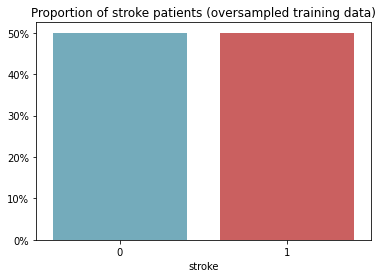

<Figure size 1440x720 with 0 Axes>

In [16]:
#X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']]
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_1', 'work_type_2', 'work_type_3', 'work_type_4', 'smoking_status_1', 'smoking_status_2', 'smoking_status_3']]
y = df[['stroke']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

oversample = SMOTE()
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

oversampled_df = X_train_SMOTE.assign(stroke = y_train_SMOTE)
stroke_proportion(y_train_SMOTE, "Proportion of stroke patients (oversampled training data)")
print("Shape before SMOTE: " + str(X_train.shape))
print("Shape after SMOTE: " + str(X_train_SMOTE.shape))

# CHAPTER 2 - DEVELOPMENT OF AN ALGORITHM <a class="anchor" id="2"></a>

## Section 2.1 - Development of a decision tree algorithm <a class="anchor" id="2.1"></a>

The algorithm that has been chosen to be implemented for the classification task of this projects is called CART (short for Classification and Regression Trees). An improved version of this algorithm is used by the `DecisionTreeClassifier` and `RandomForestClassifier` of the `sklearn.tree` library.

## CART (Classification and Regression Trees)

### Building the tree

CART is an algorithm that recursively builds binary trees (branching factor for root and inner nodes = 2) by searching in a partition the combination of feature and threshold values that will maximize the reduction in impurity obtained by splitting a given partition using a selected split candidate. Like many tree-based algorithms (like ID3, C4.5), CART builds the tree structure from the top-down by starting from a `root` partition which containins all the training data. This recursive split (from parent partition to left and right child nodes) is what ultimately allows the algorithm to build the tree structure. 

### Searching for a split candidate

For each newly created parittion, CART will look at each combination of feature and threshold in order to find a split candidate. For every feature containing `K` different values, we will always have `K-1` possible thresholds. It can also be decided (by changing the value of `max_features`) to search for a split only in a subset of randomly sampled features, this is the default behavior when a tree is initialized from the `RandomForestClassifier` (where `max_features = sqrt`).

Before searching for a possible split, the implemented algorithm will (as a first step) sort the partition entries based on the values of the selected feature. Sorting is fairly expensive, but it allows the algorithm to easily search for all thresholds (within a given feature) in linear time. The algorithm will then proceed to traverse the list of sorted examples and to evaluate all midpoints between two (different) adjecent values as a possible threshold. The reduction in impurity that would be obtained by splitting at the currently selected threshold is compared with the maximum reduction that has been registered so far for the current partition. If the current reduction is bigger than the previous best one, the details of the best split candidate are updated.

### Stopping condition

In CART, the splitting process is repeated for each newly created node until a stopping condition is reached. The decision to stop the splitting process for a given node is triggered when: 
- The partition is pure (i.e. all the examples in the partition have the same class)
- No possible split can be imposed to the current partition (i.e. All examples only have a single value per feature)
- The (user defined) maximum depth (`max_depth`) has been reached
- The threshold for the reduction is impurity (`min_impurity_delta`) cannot be satisfied by any split candidate
- The threshold for the minimum nr of examples in a partition (`min_size_part`) is not met

Whenever a stopping condition is reached, the interested partition is turned into a leaf node. Majority voting is performed in order to decide what is the predicted value of the newly created leaf.

### Split strategy

For this algorithms implementation two strategies have been offered to asses the quality of a split candidate (feature+threshold): `gini` and `entropy`

Initializing our `CustomDecisionTreeClassifier` with `strategy = gini` will cause our algorithm to use the Gini Index as a starting metric to evaluate the reduction in impurity brought upon by a given split candidate. 

The Gini Index for a partition D containing examples with C different classes is calculated as follows:

$$ Gini(D) = 1 - \sum \limits _{i=1} ^{C} (p _{i}) ^{2} $$

When considering a split candidate A (feature+threshold) for a partition D, we calculate the weighted sum of impurities of the resulting child partitions D1 and D2 as follows:

$$ Gini _{A} (D) = \frac{size(D _{1})}{size(D)} Gini(D _{1}) + \frac{size(D _{2})}{size(D)} Gini(D _{2})$$

The reduction of impurity is then simply:

$$ \Delta Gini(A) = Gini(D) - Gini _{A} (D) $$

Alternatively, the algorithm can be initialized with `strategy = entropy` to use the Information gain as a metric for the reduction in impurity.

The entropy of a partition D containing examples with C different classes is calculated as follows:

$$ Entropy(D) = - \sum \limits _{i=1} ^{C} p _{i} log _{2} (p _{i}) $$

The weighted sum of entropies for child partitions D1 and D2 originating from D via a split candidate A is:

$$ Entropy _{A} (D) = \frac{size(D _{1})}{size(D)} Entropy(D _{1}) + \frac{size(D _{2})}{size(D)} Entropy(D _{2})$$

The Information Gain is then simply:

$$ Gain(A) = Entropy(D) - Entropy _{A} (D) $$

### Partition class

To represent the structure of a node in our Decision Tree, it has been decided to create a `Partition` class that will contain all the information related to a given node.
Root and inner nodes will contain information regarding the chosen split candidate (`split_feature`, `split_value`), the level of impurity (`impurity_part`), the reduction of impurity that has been obtained with the chosen split candidate (`impurity_delta`) and the weighted sum of impurities of the child nodes obtained with the chosen split candidate (`impurity_feature_example`).
Additionally, the non-leaf nodes also have populated pointers to their child partitions (`left_part` and `right_part`). This characteristics of the partition class is what allows us to traverse the full-length of the tree by starting from the root node and jumping from child to child until a leaf node is reached.

For both root/inner nodes and leaf nodes we have information regarding the predicted class values (`prediction`) which is obtained by majority voting, and the class distribution (i.e. the number of examples for each class value, represented by `counter`).

### Predicting a class

Predicting a class value from a trained model is simply a matter of traversing the three from root to leaf. Non-leaf nodes contain information regarding the feature (`split_feature`) and threshold (`split_value`) we have to check in order to decide if we want to move to the left (example value <= partition threshold) or right (example value > partition threshold) child from the current partition. Once a leaf node is reached, the algorithm stops and checks the predicted value (`prediction`) in order to decide what the predicted class value will be for the current example.

### Complexity

TODO - What is the actual complexity of sorting + linear search? O(n * log(n))?

In [17]:
# Leaf partitions only have prediction values
class Partition:
    '''
    Class used to represent a partition
    Partitions act as nodes in the Decision Tree

    Attributes
    ----------
    split_feature: str
        Feature chosen for splitting the partition
    split_value: float
        (Threshold) Value chosen for splitting the partition
    impurity_part: float
        Impurity of the current partition
    impurity_delta: float
        Reduction in impurity by splitting using `split_feature` and `split_value`
    impurity_feature_example: float
        Weighted sum of impurities for the partitions resulting from a split at `split_feature` and `split_value`
    prediction: float
        Predicted value (majority class) at the current partition
    counter: collections.Counter
        Counter for each class in the parition
    '''
    def __init__(self, 
                 split_feature, 
                 split_value, 
                 impurity_part,
                 impurity_delta, 
                 impurity_feature_example, 
                 prediction,
                 counter):
        self.split_feature = split_feature
        self.split_value = split_value
        self.impurity_part = impurity_part
        self.impurity_delta = impurity_delta
        self.impurity_feature_example = impurity_feature_example
        self.prediction = prediction
        self.counter = counter
        self.left_part = None
        self.right_part = None

In [18]:
class CustomDecisionTreeClassifier:
    '''
    Class used to model the decision tree

    Attributes
    ----------
    strategy: str
        Strategy used to calculate the impurity of a partition
        'gini' (for gini index) or 'entropy' (for information gain)
    max_depth: int
        Maximum total depth of the tree. Root node is at depth 1
    min_impurity_delta: float
        Threshold for the reduction in impurity needed to split a partition
        If the values is not met, the interested partition is turned into a leaf node
    min_size_part: int
        Threshold for the nr of examples needed to split a partition
        If the values is not met, the interested partition is turned into a leaf node
    max_features: str, int
        The number of features (randomly) considered at each node in order to find a split point
        Note: 
            If no valid split point can be found with the initially sampled features, before turning the parition into 
            a leaf node the system will try to sample additional features until at least one combination of 
            'split_feature' and 'split_value' is found or until all possible features are exhausted
        Can be manually set (int) or as follows (str):
            'None' considers all the features of in training set
            'sqrt' considers the square root of the total nr of features in the training set
            'log2' considers the log base 2 of the total nr of features in the training set
    '''
    def __init__(self, *,
                 strategy = 'gini',
                 max_depth = None, 
                 min_impurity_delta = None, 
                 min_impurity_part = None,
                 min_size_part = 2,
                 max_features = None):
        self.strategy = strategy
        self.max_depth = max_depth # Root depth is 0
        self.min_impurity_delta = min_impurity_delta
        self.min_impurity_part = min_impurity_part
        self.min_size_part = min_size_part
        self.max_features = max_features
        self.n_classes = 0
        self.root = None

    def fit(self, 
            X, 
            y):
        '''
        Starts the process of building a Decision Tree from a training set

        Parameters
        ----------
        X: pandas.core.frame.DataFrame, numpy.ndarray
            The training examples
        y: pandas.core.frame.DataFrame, numpy.ndarray
            The training class labels
        '''
        X, y = self.data_to_numpy(X,y)
        self.n_classes = len(np.unique(y))
        self.root = self.build_tree(X, y, self.max_depth)

    @staticmethod
    def data_to_numpy(X,
                      y = None):
        '''
        Converts input dataframes to numpy arrays

        Parameters
        ----------
        X: pandas.core.frame.DataFrame, numpy.ndarray
            The training examples
        y: pandas.core.frame.DataFrame, numpy.ndarray
            The training class labels

        Returns
        ----------
        X: numpy.ndarray
            The training examples converted to a numpy array
        y: numpy.ndarray
            The training class labels converted to a (flattened) numpy array
        '''
        if(type(X) != np.ndarray):
            X = X.to_numpy()
        if((y is not None) and (type(y) != np.ndarray)):
            y = y.to_numpy()

        if(y is not None):
            return X, y.flatten()
        else:
            return X

    def build_tree(self, 
                   X, 
                   y, 
                   depth):
        '''
        Recursively builds a Decision Tree starting from a training set.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: numpy.ndarray
            The training class labels
        depth: int
            Depth counter
            Used as stop condition for the recursive call when `max_depth` is defined for the Decision Tree

        Returns
        -------
        curr_part: Partition
            The root partition (node) of the Decision Tree
        '''
        # Majority class is set as the predicted value for the current partition
        counter = Counter(y)
        prediction = counter.most_common(1)[0][0]

        # Update depth value
        if self.max_depth:
            if depth > 0:
                depth -= 1 
            else:
                return Partition(None, None, None, None, None, prediction, counter) # Return as leaf

        # Check partition size
        if y.size < self.min_size_part:
            return Partition(None, None, None, None, None, prediction, counter) # Return as leaf

        split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example = self.find_split(X, y)
        curr_part = Partition(split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example, prediction, counter)

        if(split_feature is not None):
            # Temporarely create a merged df in order to filter features and classes together
            merged_df = np.append(X, np.vstack(y), axis=1)
            
            merged_df_left = merged_df[merged_df[:,split_feature] < split_value]
            merged_df_right = merged_df[merged_df[:,split_feature] > split_value]

            curr_part.left_part = self.build_tree(
                merged_df_left[:, :-1], 
                merged_df_left[:, -1], 
                depth) # Left

            curr_part.right_part = self.build_tree(
                merged_df_right[:, :-1], 
                merged_df_right[:, -1], 
                depth) # Right  

        return curr_part

    def predict(self, 
                X):
        '''
        Predicts the class value (label) for each input example
        The tree is traversed for each provided example

        Parameters
        ----------
        X: numpy.ndarray, pandas.core.frame.DataFrame
            The examples to predict the class for

        Returns
        ----------
        y: numpy.ndarray
            The predicted class labels
        '''
        X = self.data_to_numpy(X)
        y = []

        for example in X:
            curr_part = self.root

            while curr_part.right_part:
                if example[curr_part.split_feature] <= curr_part.split_value:
                    curr_part = curr_part.left_part
                else:
                    curr_part = curr_part.right_part
            y.append(curr_part.prediction)

        return np.array(y)


    def predict_proba(self, 
                      X):
        '''
        Predicts the probability of each class value (label) for each input example

        Parameters
        ----------
        X: numpy.ndarray, pandas.core.frame.DataFrame
            The examples to predict the class for

        Returns
        ----------
        y: numpy.ndarray
            The probabilities for each class label
        '''
        X = self.data_to_numpy(X)
        y = []

        for example in X:
            curr_part = self.root

            while curr_part.right_part:
                if example[curr_part.split_feature] < curr_part.split_value:
                    curr_part = curr_part.left_part
                else:
                    curr_part = curr_part.right_part

            temp = []

            for i in range(self.n_classes):
                if(i == curr_part.prediction):
                    temp.append(1.0)
                else:
                    temp.append(0.0)

            y.append(temp)

        return np.array(y)

    # Both gini index and entropy/information gain are measures of the impurity of a node.
    def calc_impurity(self, 
                      class_occ, 
                      size_part):
        '''
        Calculates the impurity of a partition based on the chosen strategy

        Parameters
        ----------
        class_occ: Counter
            Nr of occurrences of each class value 
        size_part:
            Nr of examples in the current partition
        Returns
        ----------
        ret:
            The impurity value of the partition
        '''
        if self.strategy == 'gini':
            return (1 - sum((class_occ[curr_class]/size_part)**2 for curr_class in class_occ))
        elif self.strategy == 'entropy':
            ret = 0
            for curr_class in class_occ:
                if class_occ[curr_class]/size_part > 0:
                    ret -= class_occ[curr_class]/size_part * math.log(class_occ[curr_class]/size_part, 2)
            return ret

    def find_split(self, 
                    X, 
                    y):
            '''
            Finds the best split feature and threshold for a given partition

            Parameters
            ----------
            X: pandas.core.frame.DataFrame
                The training examples
            y: pandas.core.frame.DataFrame
                The training class labels

            Returns
            ----------
            split_feature: str
                Feature chosen for splitting the partition
            split_value: float
                (Threshold) Value chosen for splitting the partition
            impurity_delta: float
                Reduction in impurity by splitting using `split_feature` and `split_value`
            impurity_feature_example: float
                Weighted sum of impurities for the partitions resulting from a split at `split_feature` and `split_value`
            '''
            # Initialize the return values
            split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example = None, None, None, None, None

            # Return if below impurity threshold
            if((self.min_impurity_part is not None) and (impurity_part < self.min_impurity_part)):
                return split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example

            # Calculate the occurences of each class in the partition
            class_occ_part = Counter(y)

            # Return if the partition is pure
            if(sum(class_occ_part[i] > 0 for i in class_occ_part) == 1):
                return split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example

            # Calculate the impurity of the current partition
            size_part = y.size
            impurity_part = self.calc_impurity(class_occ_part, size_part)
            impurity_delta = 0

            # Sample the features to consider for the split
            X_rows, X_cols = X.shape
            n = X_cols

            if(self.max_features == 'sqrt'):
                n=round(math.sqrt(X_cols))
            elif(self.max_features == 'log2'):
                n=round(math.log2(X_cols))
            elif((self.max_features is not None) and (self.max_features <= X_cols)):
                n=self.max_features

            sampled_features = sorted(random.sample(range(0, X_cols), n))

            # Loop through all features
            for feature in sampled_features:
                # Skip ahead if the feature has only one value
                if len(np.unique(X[:,feature])) == 1:
                    continue

                # Sort the examples in increasing order for the selected feature
                # Consider the midpoint between two (different) adjecent values as a possible split point
                feature_sorted, y_sorted = zip(*sorted(zip(X[:,feature], y), key=itemgetter(0)))

                # Go through the sorted feature while keeping track of class occurences on each side (/partition)
                class_occ_left = Counter()
                for i in range(self.n_classes):
                    class_occ_left[i] = 0 # Left partition starts as empty (all class counters are set to 0)

                class_occ_right = class_occ_part.copy() # Same as occurences of each class in the partition

                for example in range(1, size_part):
                    example_class = y_sorted[example-1]

                    # Increment the example class on the left, decrement it on the right
                    class_occ_left[example_class] += 1
                    class_occ_right[example_class] -= 1

                    # Skip ahead if two adjacent values are equal
                    if feature_sorted[example] == feature_sorted[example - 1]:
                        continue

                    # Calculate the impurity of each side
                    size_left = example
                    impurity_left = self.calc_impurity(class_occ_left, size_left)

                    size_right = size_part - example
                    impurity_right = self.calc_impurity(class_occ_right, size_right)
                    
                    # Weighted sum of impurities (with selected feature at current example)
                    curr_impurity_feature_example = ((size_left/size_part) * impurity_left) + ((size_right/size_part) * impurity_right)

                    # Reduction in impurity with current split
                    curr_impurity_delta = impurity_part - curr_impurity_feature_example 

                    if(self.min_impurity_delta and curr_impurity_delta < self.min_impurity_delta):
                        continue

                    if(curr_impurity_delta > impurity_delta):
                        split_feature = feature
                        split_value = (feature_sorted[example] + feature_sorted[example-1]) / 2
                        impurity_delta = curr_impurity_delta
                        impurity_feature_example = curr_impurity_feature_example

                # If no split point was found when using a random subset of features, try to randomly sample a new one
                if((len(sampled_features) != X_cols) and (split_feature is None) and (feature == sampled_features[-1])):
                    sampled_features.append(random.sample(set(range(0, X_cols)) - set(sampled_features), 1)[0])

            return split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example

## Section 2.2 - Development of a random forest algorithm <a class="anchor" id="2.2"></a>

Now that we have a way to build binary tree using our implementation of the CART algorithm, we are ready to move a step further by implementing a Random Forest classifier (`CustomRandomForestClassifier`) that will use our `CustomDecisionTreeClassifier` as the basic building block to perform ensemble learning.

### Building a forest

Building a forest is a fairly straightforward process in which a set `CustomDecisionTreeClassifier` equal to the value defined by the `forest_size` parameter are initialized. Using the same input data for all trees and considering the same features for all node splits would create a set of identical models. Since an ensemble of nearly identical trees is fairly useless, Random Forest uses two techniques to ensure that all the models built as part of the forest are slightly different from one another:

- Feature randomness
- Bootstrap Aggregation (Bagging)

### Feature randomness

As we have seen in the previous section, setting the `max_features` variable of the `CustomDecisionTreeClassifier` influences how many features are randomly sampled when searching for a potential split in a partition. This particular parameter will allow the algorithm to increment the range of diversity between the trees that are part of the forest.

This random sampling of features is done at the node level, NOT at the tree level. Early implementations of the random forest algorithms used a technique called “random subspace method” where the random subset of features was provided at the tree level:

>“Our method relies on an autonomous, pseudo-random procedure to select a small number of dimensions from a given feature space …”

 - Ho, Tin Kam. “The random subspace method for constructing decision forests.” IEEE transactions on pattern analysis and machine intelligence 20.8 (1998): 832-844

Just like the implementation shown in this project, modern (state of the art) random forest algorithms use random sampling of features at the node level. This approach allows the algorithm to learn the relationship between different features in a more diversified way. 

This means that each tree can work with the full set of features of the training data.

>“… random forest with random features is formed by selecting at random, at each node, a small group of input variables to split on.”

 - Breiman, Leo. “Random Forests” Machine learning 45.1 (2001): 5-32.

### Bootstrapping

In addition to using a random subset of feature for each split, the trees in the Random Forest are also constructed using slightly different training data. This is achieved via a technique called bootstrapping. Bootstrapping uses sampling with replacement to construct a new version of the training dataset for every tree in the forest. Bootstrapping entails randomly sampling examples from the original dataset until a ratio size (`bootstrapping_ratio`) is reached. Sampling with replacement simply means that the same entries can be sampled multiple times from the original dataset.

### Predicting a class (Aggregation)

Once all the models in the forest have been constructed, we can start predicting labels for new data.
The technique used by the Random Forest algorithm to predict a class label is pretty straightforward. The algorithm will run the prediction (exapleined in the previous section) for every tree in the forest. Majority voting is then applied on the list of predictions and the most frequent class value is then chosen as the return value.

In [23]:
class CustomRandomForestClassifier:
    '''
    Class used to model the random forest

    Attributes
    ----------
    forest_size: int
        Controls the nr of trees in the forest
    bootstrapping: bool
        Decides whether bootstrapping is used for the trees input data
        When set to False, the whole dataset is used for each tree in the forest
    bootstrapping_ratio: float
            The ratio size of the bootstrapping sample
    strategy: str
        Strategy used to calculate the impurity of a partition in a tree
        Either 'gini' (for gini index) or 'entropy' (for information gain)
    max_depth: int
        Maximum total depth of the trees. Root node is at depth 1
    min_impurity_delta: float
        Threshold for the reduction in impurity needed to split a partition in a tree
        If the values is not met, the interested partition is turned into a leaf node
    min_size_part: int
        Threshold for the nr of examples needed to split a partition in a tree
        If the values is not met, the interested partition is turned into a leaf node
    max_features: str
        The number of features (randomly) considered at each split in a tree
        'None' considers all the features in the training set
        'sqrt' considers the square root of the total nr of features in the training set
        'log2' considers the log base 2 of the total nr of features in the training set
    '''
    def __init__(self, *,
                 forest_size = 100,
                 bootstrapping = True,
                 bootstrapping_ratio = 1.0,
                 strategy = 'gini',
                 max_depth = None, 
                 min_impurity_delta = None, 
                 min_impurity_part = None,
                 min_size_part = 2,
                 max_features = 'sqrt'):
        self.strategy = strategy
        self.max_depth = max_depth # Root depth is 0
        self.bootstrapping = bootstrapping
        self.bootstrapping_ratio = bootstrapping_ratio
        self.forest_size = forest_size
        self.min_impurity_delta = min_impurity_delta
        self.min_impurity_part = min_impurity_part
        self.min_size_part = min_size_part
        self.max_features = max_features
        self.n_classes = 0
        self.forest = []

    def fit(self, 
            X, 
            y):
        '''
        Starts the process of building a Random Forest

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: numpy.ndarray
            The training class labels
        '''
        X, y = self.data_to_numpy(X, y)

        # Flush old forest
        if len(self.forest) > 0:
            self.forest = []

        self.n_classes = len(np.unique(y))

        for i in range(self.forest_size):
            curr_tree = CustomDecisionTreeClassifier(strategy = self.strategy,
                                                     max_depth = self.max_depth,
                                                     min_impurity_delta = self.min_impurity_delta,
                                                     min_impurity_part = self.min_impurity_part,
                                                     min_size_part = self.min_size_part,
                                                     max_features = self.max_features)

            if self.bootstrapping:
                curr_X, curr_y = self.bootstrap(X, y, self.bootstrapping_ratio)
                curr_tree.fit(curr_X, curr_y)
            else:
                curr_tree.fit(X, y)

            self.forest.append(curr_tree)

    @staticmethod
    def data_to_numpy(X,
                      y = None):
        '''
        Changes input dataframes to numpy arrays

        Parameters
        ----------
        X: pandas.core.frame.DataFrame, numpy.ndarray
            The training examples
        y: pandas.core.frame.DataFrame, numpy.ndarray
            The training class labels

        Returns
        ----------
        X: numpy.ndarray
            The training examples converted to a numpy array
        y: numpy.ndarray
            The training class labels converted to a (flattened) numpy array
        '''
        if(type(X) != np.ndarray):
            X = X.to_numpy()
        if((y is not None) and (type(y) != np.ndarray)):
            y = y.to_numpy()

        if(y is not None):
            return X, y.flatten()
        else:
            return X

    @staticmethod
    def bootstrap(X, 
                  y, 
                  ratio = 1):
        '''
        Creates a new dataset (X_bootstrap, y_bootstrap) by randomly selecting examples from the original dataset (X, y) 
        until a ratio size is reached
        The same examples from the original dataset may be sampled multiple times (sampling with replacement)

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: numpy.ndarray
            The training class labels
        ratio: float
            The ratio size of the sample

        Returns
        ----------
        X_bootstrap: pandas.core.frame.DataFrame
            New feature dataframe created from the sampled entries
        y_bootstrap: numpy.ndarray
            New class dataframe created from the sampled entries
        '''
        # Temporarily create a merged df to sample from
        merged_df = np.append(X, np.vstack(y), axis=1)

        samples_idx = np.random.choice(merged_df.shape[0], round(merged_df.shape[0]*ratio))
        merged_df[samples_idx]

        X_bootstrap = merged_df[:, :-1]
        y_bootstrap = merged_df[:, -1]

        return X_bootstrap, y_bootstrap

    def predict(self, 
                X):
        '''
        Predicts the class value (label) for each input example

        Parameters
        ----------
        X: numpy.ndarray, pandas.core.frame.DataFrame
            The examples to predict the class for

        Returns
        ----------
        y: numpy.ndarray
            The predicted class labels
        '''
        X = self.data_to_numpy(X)
        y_forest = [] # Each index is the list of predictions from one tree

        for tree in self.forest:
            y_forest.append(tree.predict(X))

        # Zip together prediction for same entry over different trees, extract most common class (majority voting)
        return np.array(list(map(lambda i: Counter(i).most_common(1)[0][0], zip(*y_forest))))
    
    def predict_proba(self,
                      X):
        '''
        Predicts the probability of each class value (label) for each input example
        This probability is based on the output of the `predict` method for each tree in the forest for a
        given example

        Parameters
        ----------
        X: numpy.ndarray, pandas.core.frame.DataFrame
            The examples to predict the class for

        Returns
        ----------
        y: numpy.ndarray
            The probabilities for each class label
        '''
        X = self.data_to_numpy(X)
        y_forest = [] # Each index is the list of predictions from one tree

        for tree in self.forest:
            y_forest.append(tree.predict(X))

        # Zip together prediction for same entry over different trees, count the nr of predictions for each class
        count_matrix = np.array(list(map(lambda i: Counter(i), zip(*y_forest))))
        res = []

        for i in range(len(count_matrix)):
            temp = []
            temp_total = sum(count_matrix[i].values())
            for j in range(self.n_classes):
                temp.append(count_matrix[i][j]/temp_total)
            res.append(temp)

        return np.array(res)

## A note on regression
TODO

# CHAPTER 3 - TRAINING & SCORING THE ALGORITHMS <a class="anchor" id="3"></a>

Now that ...

We define the concepts of true positive, true negative, false positive and false negative as follows:

- **True positives**: positive tuples correctly labeled
- **True negatives**: negative tuples correctly labeled 
- **False positives**: negative tuples incorrectly labeled (we should have predicted 0 but we predicted 1)
- **False negatives**: positive tuples incorrectly labeled (we should have predicted 1 but we predicted 0)

The `score_model` function will utilize the following metrics to evaluate our Decision Tree and Random Forest algorithms:

- **Accuracy**: Measures how many class labels the model was able to correctly predict over the total number of prediction. An important aspect to keep in mind is that accuracy is not a very good metric if we are trying to evaluate a model when the classes are highly unbalanced. Accuracy is expressed as follows:

$$ Accuracy = \frac{\textrm{Nr of correct predictions}}{\textrm{Total nr of predictions}} = \frac{TP + TN}{TP + TN + FP + FN} $$

- **Precision**: For a given class, precision indicates how many time the model correctly predicted the class over the total number of times the class was predicted. For a class C, we express preicsion as follows:

$$ Precision(C) = \frac{\textrm{Nr of correct C predictions}}{\textrm{Total nr of C predictions}} = \frac{TP}{TP + FP} $$

- **Recall**: For a given class, recall indicates the number of times the model correctly predicted the class over the true number of times the class appears. For a class C, we express recall as:

$$ Recall(C) = \frac{\textrm{Nr of correct C predictions}}{\textrm{Total nr of C occurrences}} = \frac{TP}{TP + FN} $$

- **F1 Score**: Is the armonic mean of precision and recall. Intuitively, if both precision and recall are high, the F1 Score will be high. If one is high and one is low or if both are low, the F1 Score will be low. For a class C, we express the F1 Score as follows:

$$ \textrm{F1 Score(C)} = 2 * \frac{Precision(C)*Recall(C)}{Precision(C)+Recall(C)} $$

All these metrics are put together in the classification report. The report will contain the values for precision, recall and f1 score for all classes (0 and 1 in our case), a support column indicating the number of entries belonging to each class, the accuracy over the whole training set, the macro average (does not consider proportions) for all three metrics and the weighted average (does consider proportions) for all three metrics. 

Additionally, we will also print a confusion matrix, indicating 

In [47]:
def score_model(model, 
                X,
                y):
    '''
    Prints the model score (for training and testing set) in terms of:
        Classification report
        Accuracy score
        Area Under the Receiver Operating Characteristic Curve (ROC AUC)
        F1 score
        Confusion Matrix

    Parameters
    ----------
    model: 
        The trained model to score
    X: numpy.ndarray, pandas.core.frame.DataFrame
        The input examples
    y: numpy.ndarray, pandas.core.frame.DataFrame
        The input classes
    '''
    y_predict = model.predict_proba(X)
    print(f"Accuracy score: {accuracy_score(y, np.around(y_predict[:, 1]))}")
    print(f"f1 score: {f1_score(y,np.around(y_predict[:, 1]))}")
    print("\nClassification report:")
    print(classification_report(y, np.around(y_predict[:, 1])))
    #print(f"Cross val score: {cross_val_score(model, X, y, cv=5).mean()}")
    plot_confusion_matrix(y, y_predict)

def plot_confusion_matrix(y, y_predict):
    cm = confusion_matrix(y, np.around(y_predict[:, 1]), normalize = 'true')
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real") 
    ax.set_title("Confusion Matrix")
    plt.show()

## Decision tree classifier

Run time: 1.8809518814086914 

Accuracy score: 0.8608282416836388
f1 score: 0.1276595744680851

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1401
           1       0.09      0.21      0.13        72

    accuracy                           0.86      1473
   macro avg       0.52      0.55      0.53      1473
weighted avg       0.91      0.86      0.89      1473



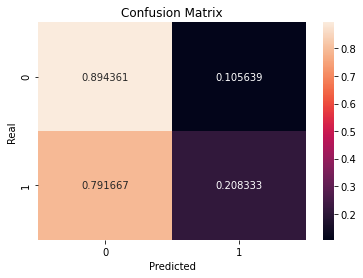

In [48]:
import time
start_time = time.time()
test_tree = CustomDecisionTreeClassifier()
test_tree.fit(X_train_SMOTE, y_train_SMOTE)
print(f"Run time: {time.time() - start_time} \n")

'''print("TRAIN DATA")
score_model(test_tree, X_train, y_train)
print("\nTEST DATA")'''
score_model(test_tree, X_test, y_test)

## Random forest classifier

<ipython-input-18-ca791de74d62>:357: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_features.append(random.sample(set(range(0, X_cols)) - set(sampled_features), 1)[0])
Run time: 63.87878203392029
TRAIN DATA
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3298
           1       0.85      1.00      0.92       137

    accuracy                           0.99      3435
   macro avg       0.92      1.00      0.96      3435
weighted avg       0.99      0.99      0.99      3435

Accuracy score: 0.992721979621543
ROC AUC score: 0.9999601616551504
f1 score: 0.9163879598662207


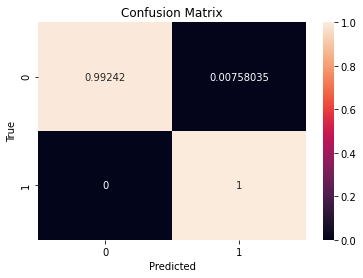


TEST DATA
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1401
           1       0.15      0.28      0.20        72

    accuracy                           0.89      1473
   macro avg       0.56      0.60      0.57      1473
weighted avg       0.92      0.89      0.90      1473

Accuracy score: 0.8893414799728445
ROC AUC score: 0.8077514077246412
f1 score: 0.19704433497536947


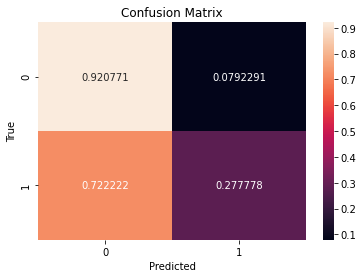

In [26]:
import time
start_time = time.time()
test_forest = CustomRandomForestClassifier()
test_forest.fit(X_train_SMOTE, y_train_SMOTE)
print(f"Run time: {time.time() - start_time}")

print("TRAIN DATA")
score_model(test_forest, X_train, y_train)
print("\nTEST DATA")
score_model(test_forest, X_test, y_test)

# CHAPTER 4 - COMPARING RESULTS WITH AN EXISTING SOLUTION <a class="anchor" id="4"></a>

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1401
           1       0.09      0.19      0.12        72

    accuracy                           0.86      1473
   macro avg       0.52      0.55      0.53      1473
weighted avg       0.91      0.86      0.89      1473

Accuracy score: 0.8649015614392397
ROC AUC score: 0.5469010230787532
f1 score: 0.12334801762114536


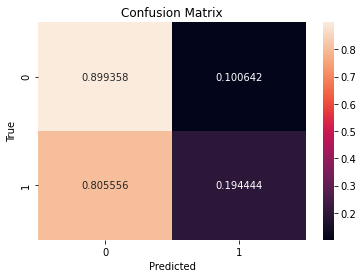

In [27]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_SMOTE, y_train_SMOTE)

'''print("TRAIN DATA")
score_model(clf, X_train, y_train)
print("\nTEST DATA")'''
score_model(clf, X_test, y_test)

In [28]:
'''fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=900)
tree.plot_tree(clf)
fig.savefig('imagename.png')'''

"fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=900)\ntree.plot_tree(clf)\nfig.savefig('imagename.png')"

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1401
           1       0.14      0.21      0.17        72

    accuracy                           0.90      1473
   macro avg       0.55      0.57      0.56      1473
weighted avg       0.92      0.90      0.91      1473

Accuracy score: 0.8981670061099797
ROC AUC score: 0.8086138869061781
f1 score: 0.16666666666666669


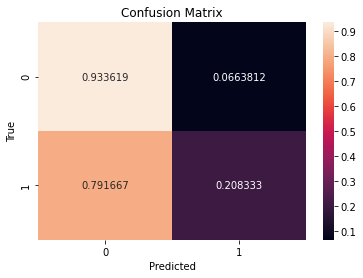

In [29]:
rfc = RandomForestClassifier()
rfc.fit(X_train_SMOTE.to_numpy(), y_train_SMOTE.values.flatten())

'''print("TRAIN DATA")
score_model(rfc, X_train, y_train)
print("\nTEST DATA")'''
score_model(rfc, X_test, y_test)

## Dummy dataset sanity check

In [30]:
from sklearn import datasets
cancer = datasets.load_breast_cancer()
y_cancer = cancer.target
X_cancer = cancer.data
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer, y_cancer, test_size=0.3, random_state=42)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        63
           1       0.96      0.97      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

Accuracy score: 0.9590643274853801
ROC AUC score: 0.9959582598471488
f1 score: 0.9677419354838711


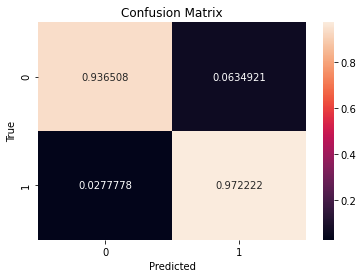

In [33]:
dummy_forest = CustomRandomForestClassifier()
dummy_forest.fit(X_train_cancer, y_train_cancer)
score_model(dummy_forest, X_test_cancer, y_test_cancer)

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        63
           1       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171

Accuracy score: 0.9707602339181286
ROC AUC score: 0.9961052322163434
f1 score: 0.9771689497716894


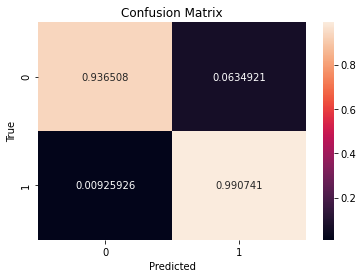

In [34]:
dummy_forest_scikit = RandomForestClassifier()
dummy_forest_scikit.fit(X_train_cancer, y_train_cancer)
score_model(dummy_forest_scikit, X_test_cancer, y_test_cancer)

# CHAPTER 5 - CONCLUSIONS <a class="anchor" id="5"></a>